**KNN Model**

---



# Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
try:
  import mlextend
  assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
    !pip install -U mlxtend
import mlxtend
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from scipy import stats
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0


# Download data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mannokat","key":"e8b5b50982a37478ca3aec18d281fed5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d crawford/emnist

100% 1.24G/1.24G [00:19<00:00, 65.7MB/s]
100% 1.24G/1.24G [00:19<00:00, 67.4MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "emnist.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
train_data = pd.read_csv("/content/emnist-letters-train.csv", header = None)
test_data = pd.read_csv("/content/emnist-letters-test.csv", header = None)
mapping = pd.read_csv("/content/emnist-letters-mapping.txt", sep = ' ', header = None)

# Data Preparation & EDA

**Explore the data (train and test data)**

In [ ]:
train_data = train_data.rename(columns= {0: 'label'})
test_data = test_data.rename(columns= {0: 'label'})
train_data.describe()

,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,88800.000000,88800.0,88800.0,88800.0,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,...,88800.0,88800.0,88800.0,88800.000000,88800.000000,88800.0,88800.0,88800.0,88800.0,88800.0
mean,13.519268,0.0,0.0,0.0,0.000011,0.003986,0.016757,0.024640,0.021486,0.017140,...,0.0,0.0,0.0,0.003041,0.000360,0.0,0.0,0.0,0.0,0.0
std,7.502931,0.0,0.0,0.0,0.003356,0.544039,1.547686,1.915976,1.803270,1.620194,...,0.0,0.0,0.0,0.823445,0.107385,0.0,0.0,0.0,0.0,0.0
min,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,7.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,14.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,20.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,26.000000,0.0,0.0,0.0,1.000000,107.000000,213.000000,217.000000,214.000000,216.000000,...,0.0,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"train_data.shape = {train_data.shape}")
print(f"test_data.shape = {test_data.shape}")
train_data.head()

train_data.shape = (88800, 785)
test_data.shape = (14800, 785)


,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


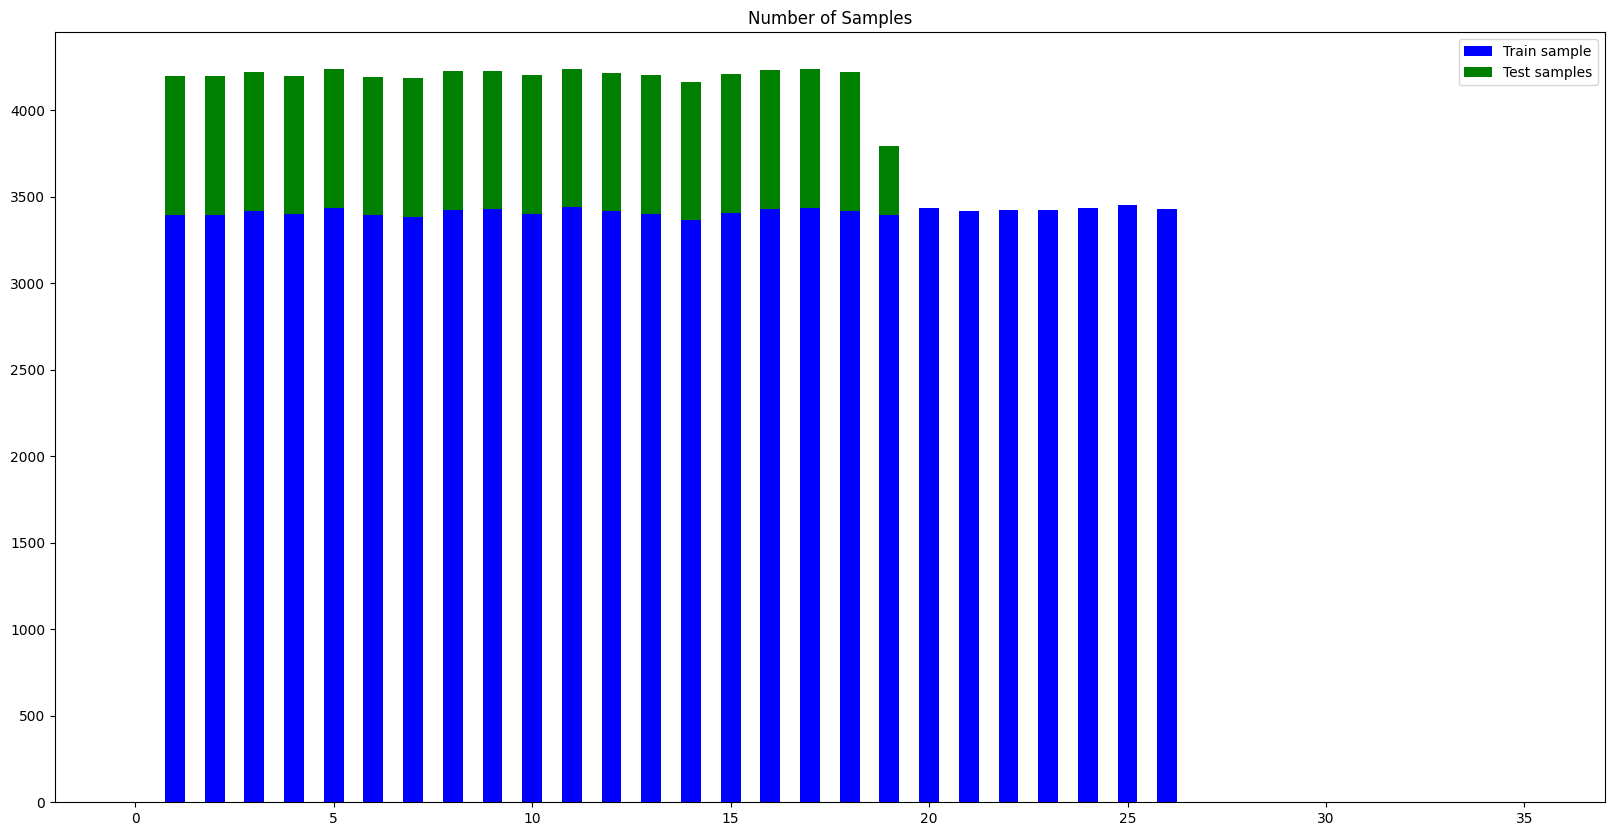

In [ ]:
### Khảo sát số samples/class
nbOfSamplesTrain = [0] * 36
nbOfSamplesTest = [0] * 36
labels = list(range(36))

for label in train_data['label']:
    if label not in labels:
        labels.append(int(label))
        nbOfSamplesTrain.append(0)
        nbOfSamplesTest.append(0)
labels.sort()

for label in train_data['label']:
    nbOfSamplesTrain[int(label)] += 1

for label in test_data['label']:
    if int(label) in labels:
      nbOfSamplesTest[int(label)] += 1

plt.figure(figsize = (20,10))
plt.bar(x = labels,
         height = nbOfSamplesTrain,
         width = 0.5,
         color = 'b',
         label = "Train sample")
plt.bar(x = labels,
         height = nbOfSamplesTest,
         width = 0.5,
         bottom = nbOfSamplesTrain,
         color = 'g',
         label = "Test samples")
plt.legend()
plt.title("Number of Samples")

plt.show()

In [ ]:
### Dictionary map from idx to character
map_dict = {}
asc_code = mapping[1].values
for i, v in enumerate(asc_code):
    map_dict[i] = chr(v)
map_dict

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

**Filter out the lowercase letters**

In [ ]:
digit_range = np.arange(0, 10)
character_range = np.arange(10, 36)
acceptable_range = np.arange(0, 36)

all_train = train_data[train_data.label.isin(acceptable_range)]
all_test = test_data[test_data.label.isin(acceptable_range)]
digit_train = train_data[train_data["label"].isin(digit_range)]
digit_test = test_data[test_data["label"].isin(digit_range)]
char_train = train_data[train_data["label"].isin(character_range)]
char_test = test_data[test_data["label"].isin(character_range)]
all_train = all_train.reset_index(drop=True)
all_test = all_test.reset_index(drop=True)
digit_train = digit_train.reset_index(drop=True)
digit_test = digit_test.reset_index(drop=True)
char_train = char_train.reset_index(drop=True)
char_test = char_test.reset_index(drop=True)

**Split X, y from data. Normalize the X**

In [ ]:
### Lấy X, y của train_data và test_data
y = all_train['label']
X = all_train.drop(columns=['label'])
y_test = all_test['label']
X_test = all_test.drop(columns=['label'])

In [ ]:
### Normalize
X /= 255.0
X_test /= 255.0

In [ ]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y.head()

0    23
1     7
2    16
3    15
4    23
Name: label, dtype: int64

**Visualize a image/sample**

In [ ]:
def flip_rotate(image):
    """ Flip ảnh và Xoay ảnh 90 độ ngược chiều kim đồng hồ"""
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape(W * H)

def get_image(image):
    """ convert từ mảng (1,784) -> (28,28) """
    W = 28
    H = 28
    image = image.reshape(W, H)
    return image

idx_sample = 400

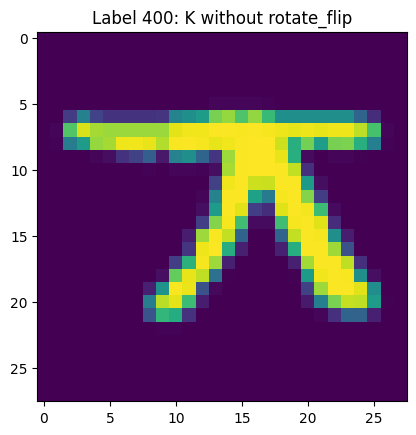

In [ ]:
### Không flip_rotate
plt.imshow(get_image(np.array(X.take([idx_sample-1]))))
plt.title(f"Label {idx_sample}: {map_dict[y[idx_sample]]} without rotate_flip")
plt.show()

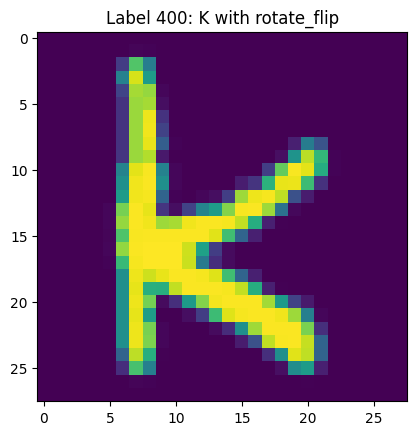

In [ ]:
### Có flip_rotate
plt.imshow(get_image(flip_rotate(np.array(X.take([idx_sample-1])))))
plt.title(f"Label {idx_sample}: {map_dict[y[idx_sample]]} with rotate_flip")
plt.show()

# Apply rotate_flip for data

In [ ]:
X = (np.apply_along_axis(flip_rotate, 1, X)).reshape(-1, 784) # type(X) = numpy.ndarray
X_test = (np.apply_along_axis(flip_rotate, 1, X_test)).reshape(-1, 784) # type(X_test) = numpy.ndarray
# Convert to numpy.ndarray
y = y.to_numpy()
y_test = y_test.to_numpy()

**Train - validation split with stratified**

We let training set = 80% train_data and validation set = 20% train_data

In [ ]:
map_dict = {}
asc_code = mapping[1].values

# Assuming you have 36 possible labels (0 to 35)
for i, v in enumerate(asc_code):
    map_dict[i+1] = chr(v)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 42, stratify = y)



In [ ]:
print(f"X_train.shape = {X_train.shape} | {type(X_train)}")
print(f"X_val.shape = {X_val.shape} | {type(X_val)}")
print(f"X_test.shape = {X_test.shape} | {type(X_test)}")

X_train.shape = (71040, 784) | <class 'numpy.ndarray'>
X_val.shape = (17760, 784) | <class 'numpy.ndarray'>
X_test.shape = (14800, 784) | <class 'numpy.ndarray'>


In [ ]:
print(f"y_train.shape = {y_train.shape} | {type(y_train)}")
print(f"y_val.shape = {y_val.shape} | {type(y_val)}")
print(f"y_test.shape = {y_test.shape} | {type(y_test)}")

y_train.shape = (71040,) | <class 'numpy.ndarray'>
y_val.shape = (17760,) | <class 'numpy.ndarray'>
y_test.shape = (14800,) | <class 'numpy.ndarray'>


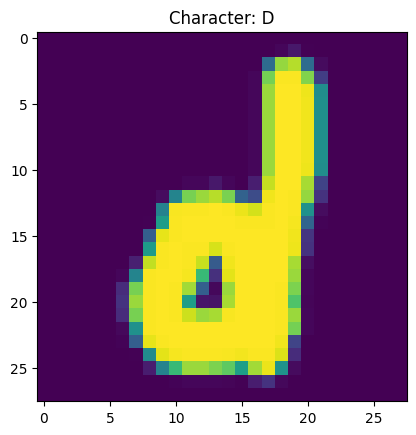

In [ ]:
idx_sample =11
plt.imshow(get_image(X_train[idx_sample]))
plt.title(f"Character: {map_dict[y_train[idx_sample]]}")
plt.show()

# Tune n_components (PCA) and n_neighbors (KNN) for model

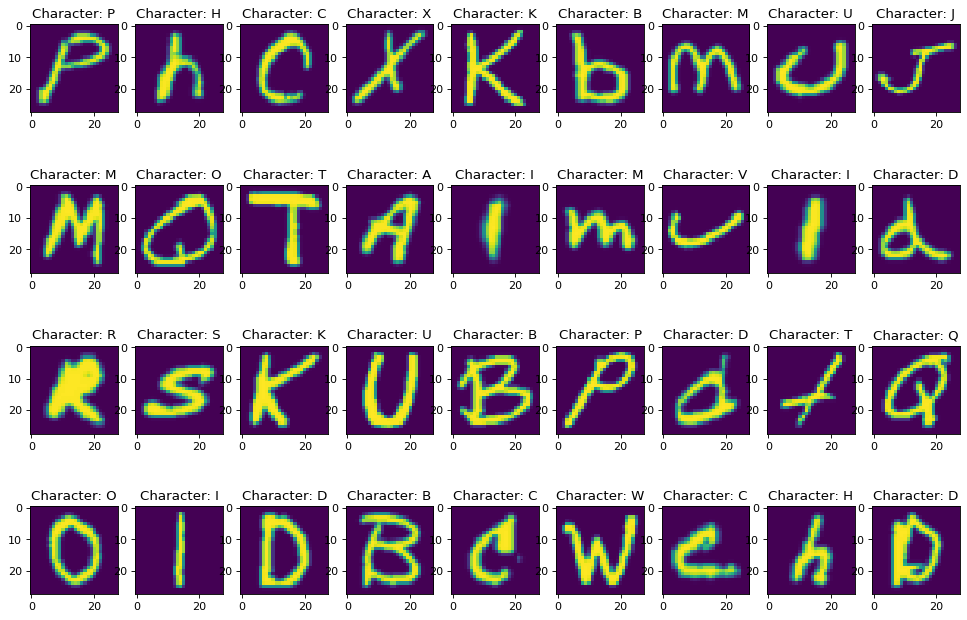

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
for i in range(100, 136):
    plt.subplot(4,9,i-99)
    plt.imshow(get_image(X_train[i]))
    plt.title(f"Character: {map_dict[y_train[i]]}")

**Accuracy according to n_components of PCA**

In [ ]:
list_n_components = [30 ,50, 100, 150, 200, 350, 400]
list_acc = []

for n in list_n_components:
  print(f"Test with n_components = {n}")
  ### 0. PCA cho X và split train-val
  newPCA = PCA(n_components = n)
  X_pca = newPCA.fit_transform(X)
  X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_pca, y, test_size = 0.2, train_size = 0.8, random_state = 42, stratify = y)

  ### 1. Create model
  next_model = KNeighborsClassifier(n_neighbors = 4,
                                  weights = 'distance',
                                  algorithm = 'brute')

  ### 2. Fit model
  next_model.fit(X_train_pca, y_train_pca)

  ### 3. Predict model
  t1 = time.time()
  y_pred = next_model.predict(X_val_pca)
  t2 = time.time()
  print(f"Pred time: {t2 - t1}")

  ### 4. Đánh giá accuracy
  acc = accuracy_score(y_val_pca, y_pred)

  list_acc.append(acc)
  print(f"Accuracy: {acc}")
  print(f"End test n_components = {n}\n")

Test with n_components = 30
Pred time: 10.919483184814453
Accuracy: 0.8778716216216216
End test n_components = 30

Test with n_components = 50
Pred time: 10.074257850646973
Accuracy: 0.8778153153153153
End test n_components = 50

Test with n_components = 100
Pred time: 13.516479253768921
Accuracy: 0.8690315315315316
End test n_components = 100

Test with n_components = 150
Pred time: 17.297091484069824
Accuracy: 0.8624436936936937
End test n_components = 150

Test with n_components = 200
Pred time: 22.383223295211792
Accuracy: 0.859740990990991
End test n_components = 200

Test with n_components = 350
Pred time: 36.5082528591156
Accuracy: 0.8567567567567568
End test n_components = 350

Test with n_components = 400
Pred time: 40.43024826049805
Accuracy: 0.8561936936936937
End test n_components = 400



The best value of n_components = 50
Accuracy: 0.8782657657657658


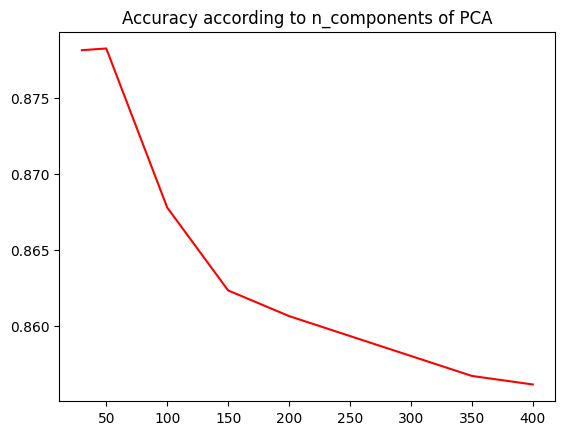

In [ ]:
best_n = list_n_components[list_acc.index(max(list_acc))]
print(f"The best value of n_components = {best_n}")
print(f"Accuracy: {max(list_acc)}")
plt.plot(list_n_components, list_acc, 'r')
plt.title("Accuracy according to n_components of PCA")
plt.show()

**Confusion matrix**

In [ ]:
# class names 'A' to 'Z'
class_names = [chr(ord('A') + i) for i in range(26)]
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

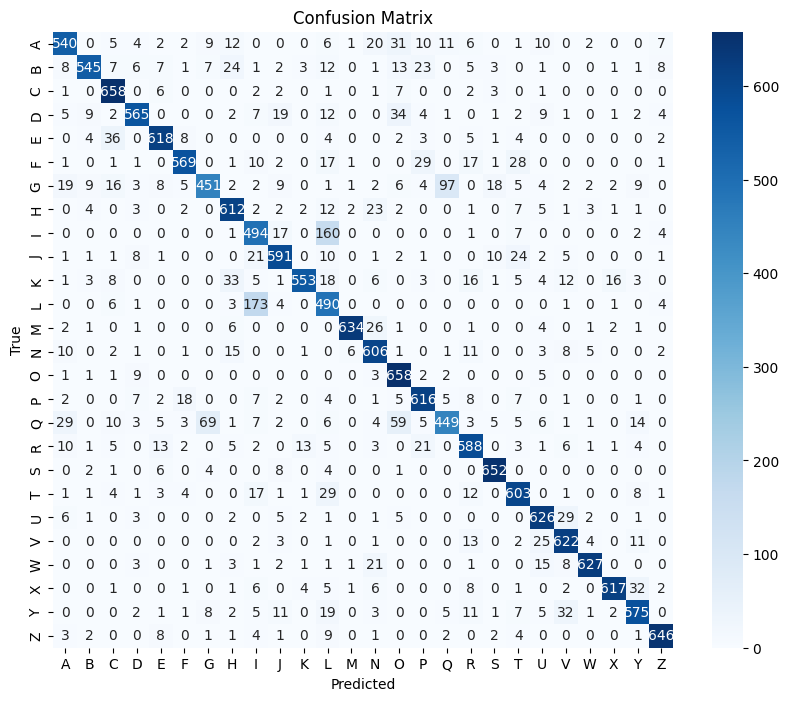

In [ ]:
plot_confusion_matrix(y_val_pca, y_pred, class_names)

**F1 Score, Precision and Recall average matrix**

In [ ]:
from sklearn.metrics import f1_score, classification_report

def calculate_f1_score_matrix(y_true, y_pred, labels, map_dict):
    labels_str = [str(label) for label in labels]
    f1_matrix = f1_score(y_true, y_pred, labels=labels, average=None)
    report = classification_report(y_true, y_pred, labels=labels_str, target_names=[map_dict[label] for label in labels], output_dict=True)
    return f1_matrix, report

# Example usage
y_pred = next_model.predict(X_val_pca)
labels = list(map_dict.keys())
f1_matrix, report = calculate_f1_score_matrix(y_val_pca, y_pred, labels, map_dict)

# Display F1 score matrix
print("F1 Score Matrix:")
for i, label in enumerate(labels):
    print(f"{map_dict[label]} (label {label}): {f1_matrix[i]:.4f}")

# Display classification report
print("\nClassification Report:")
for label in labels:
    label_str = map_dict[label]
    print(f"  Label {label} ({map_dict[label]}):")
    print(f"  Precision: {report[label_str]['precision']:.4f}")
    print(f"  Recall: {report[label_str]['recall']:.4f}")
    print(f"  F1-Score: {report[label_str]['f1-score']:.4f}")

F1 Score Matrix:
A (label 1): 0.8188
B (label 2): 0.8630
C (label 3): 0.9088
D (label 4): 0.8686
E (label 5): 0.9042
F (label 6): 0.8781
G (label 7): 0.7351
H (label 8): 0.8675
I (label 9): 0.6795
J (label 10): 0.8666
K (label 11): 0.8722
L (label 12): 0.6490
M (label 13): 0.9555
N (label 14): 0.8639
O (label 15): 0.8721
P (label 16): 0.8756
Q (label 17): 0.7127
R (label 18): 0.8442
S (label 19): 0.9477
T (label 20): 0.8602
U (label 21): 0.8879
V (label 22): 0.8785
W (label 23): 0.9400
X (label 24): 0.9271
Y (label 25): 0.8475
Z (label 26): 0.9451

Classification Report:
  Label 1 (A):
  Precision: 0.8438
  Recall: 0.7953
  F1-Score: 0.8188
  Label 2 (B):
  Precision: 0.9332
  Recall: 0.8027
  F1-Score: 0.8630
  Label 3 (C):
  Precision: 0.8613
  Recall: 0.9620
  F1-Score: 0.9088
  Label 4 (D):
  Precision: 0.9098
  Recall: 0.8309
  F1-Score: 0.8686
  Label 5 (E):
  Precision: 0.9088
  Recall: 0.8996
  F1-Score: 0.9042
  Label 6 (F):
  Precision: 0.9222
  Recall: 0.8380
  F1-Score: 0.8

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_f1_score_matrix(y_true, y_pred, labels, map_dict):
    f1_matrix_average = f1_score(y_true, y_pred, labels=labels, average='weighted')
    # plot_matrix(f1_matrix_average, labels, map_dict, "F1-Score Matrix", "F1-Score")

def plot_precision_matrix(y_true, y_pred, labels, map_dict):
    precision_matrix = precision_score(y_true, y_pred, labels=labels, average='weighted')
    # plot_matrix(precision_matrix, labels, map_dict, "Precision Matrix", "Precision")

def plot_recall_matrix(y_true, y_pred, labels, map_dict):
    recall_matrix = recall_score(y_true, y_pred, labels=labels, average='weighted')
    # plot_matrix(recall_matrix, labels, map_dict, "Recall Matrix", "Recall")

def plot_matrix(matrix, labels, map_dict, title, ylabel):
    # Create a matrix of Precision or Recall scores and labels
    matrix = np.array(matrix).reshape(1, -1)
    labels = [map_dict[label] for label in labels]

    # Create a heatmap
    plt.figure(figsize=(10, 5))
    cax = plt.matshow(matrix, cmap="YlGnBu")
    plt.colorbar(cax)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()




In [ ]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

y_pred = next_model.predict(X_val_pca)

# F1_score matrix
labels = list(map_dict.keys())
plot_f1_score_matrix(y_val_pca, y_pred, labels, map_dict)

#  Precision Matrix
labels = list(map_dict.keys())
plot_precision_matrix(y_val_pca, y_pred, labels, map_dict)

#  Recall Matrix
labels = list(map_dict.keys())
plot_recall_matrix(y_val_pca, y_pred, labels, map_dict)


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_average_performance(X_val_pca, y_val_pca, model, labels, map_dict):
    y_pred = model.predict(X_val_pca)
    labels_str = [str(label) for label in labels]

    # Calculate F1-score, precision, and recall for each label
    f1_matrix = f1_score(y_val_pca, y_pred, labels=labels, average=None)
    precision_matrix = precision_score(y_val_pca, y_pred, labels=labels, average=None)
    recall_matrix = recall_score(y_val_pca, y_pred, labels=labels, average=None)

    # Calculate average F1-score, precision, and recall
    avg_f1 = f1_score(y_val_pca, y_pred, labels=labels_str, average='weighted')
    avg_precision = precision_score(y_val_pca, y_pred, labels=labels_str, average='weighted')
    avg_recall = recall_score(y_val_pca, y_pred, labels=labels_str, average='weighted')

    # Display average performance metrics
    print(f"Average F1-score: {avg_f1:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")

    # Return the average metrics
    return avg_f1, avg_precision, avg_recall

# Example usage
avg_f1, avg_precision, avg_recall = calculate_average_performance(X_val_pca, y_val_pca, next_model, labels, map_dict)


Average F1-score: 0.8565
Average Precision: 0.8612
Average Recall: 0.8561


Calculate the flops

In [ ]:
import numpy as np

def calculate_flops(X_train, X_val, y_train, y_val, n_components, n_neighbors):
  """Calculates the FLOPS (in billions) for the KNN with PCA program above.

  Args:
    X_train: A numpy array containing the training data.
    X_val: A numpy array containing the validation data.
    y_train: A numpy array containing the training labels.
    y_val: A numpy array containing the validation labels.
    n_components: The number of components to use in PCA.
    n_neighbors: The number of neighbors to use in KNN.

  Returns:
    A float representing the FLOPS (in billions).
  """

  # Calculate the FLOPS for PCA
  flops_pca = n_components * X_train.shape[1] * X_train.shape[0]

  # Calculate the FLOPS for KNN
  flops_knn = n_neighbors * X_val.shape[1] * X_val.shape[0]

  # Total FLOPS
  flops_total = flops_pca + flops_knn

  # Convert FLOPS to billions
  flops_billions = flops_total / 10**9

  return flops_billions


In [ ]:
calculate_flops(X_train, X_val, y_train, y_val, n_components=best_n, n_neighbors=4)


2.84046336